# Домашнее задание о векторизации текстов

В задании вам предстоит сравнить несколько методов снижения размерности
* PCA
* t-SNE

а так же попробовать осуществить тематическое моделирование методом LDA.

**Формат сдачи задания** -- указание в гуглформе ссылки на тетрадь с решением + ответ на вопросы (см. последние вопросы первой задачи) в форме. Форма появится ближе к дедлайну.

**Дедлайн** 23.59 7 октября MSK.  

ДЗ предполагает возможность получения **до 12 баллов** по десятибалльной шкале. Оценки 11 и 12 поступают в ведомость, как оценки 11 и 12.

---

Если вы уже хорошо знакомы с снижением размерности, реализуйте первую задачу, используя не Bag-of-Words векторы текстов, а эмбеддинги текстов, полученные алгоритмом на ваш выбор. 
**Если вы собираетесь решать задачу так, то, приступая, сообщите об этом @oserikov в телеграме.**

Если вы уже хорошо знакомы ещё и с векторизацией текстов эмбеддингами, напишите @oserikov для обсуждения замены первой задачи на другую.


In [ ]:
! pip install razdel

In [ ]:
! pip install pymorphy2

In [ ]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
! python -m spacy download en

In [ ]:
import spacy
nlp = spacy.load('en')

In [ ]:
import gensim
import re
import os

import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from string import punctuation
from razdel import tokenize
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim import matutils
from gensim.models.ldamodel import LdaModel

In [ ]:
from tqdm.auto import tqdm

tqdm.pandas()

# [6 баллов] Задача о снижении размерности




[Вот](https://drive.google.com/drive/folders/1HX5rz4UZHtbzhPguUFolOg-xm6HFc0KO?usp=sharing) корпус, однажды собранный без особенных размышлений.
Это -- корпус любительской литературы. Он был собран для забавы и непонятно, какая природа у представленных там текстов.

Вам предстоит оценить, насколько эти тексты интересны в качестве простого датасета для задачи классификации: информативны ли Bag-of-Words векторы в смысле разделения текстов по жанрам.

---

### Постановка задачи

**Задача**: взяв фанифики и два каких-то других жанра из корпуса, визуализировать их BoW-представления на плоскости.

---

Визуализацию стоит осуществлять scatter-плотом, информацию о принадлежности документа какому-то жанру стоит передавать цветом.

Количество документов, представляющих каждый жанр, стоит подобрать семплированием нужного количества элементов под доступные вычислительные ресурсы -- полный корпус точно слишком велик.

Гиперпараметры BoW-векторизатора стоит подобрать под доступные вычислительные ресурсы -- если код работает дольше часа, то стоит упростить вычислительную задачу: подобрать другие гиперпараметры векторизации или уменьшить выборку.

#### Критерии


* **1 БАЛЛ**: 
  * В выбранных документах осуществлена какая-то **стандартная предобработка текста**: удалены стоп-слова и мусорные токены (e.g. html-теги), проведена лемматизация.  
  Решение о каждой конкретной детали предобработки остаётся на усмотрение студентов: каждое нестандартное действие (e.g. отказ от лемматизации или удаление каких-то особенных токенов) стоит пояснить коротким комментарием, описывающим мотивацию.
  * Получены **Bag-of-Words векторы** документов, выбранных для исследования. 
* **1 БАЛЛ**: получена визуализация документов на плоскости **методом главных компонент** снижения размерности Bag-of-Words векторов.
* **1 БАЛЛ**: получена визуализация документов на плоскости методом **t-SNE** снижения размерности Bag-of-Words векторов.
* **1 БАЛЛ**: на полученных визуализациях **получилось передать цветом точек классы** документов; понятно, точка какого цвета относится к какому классу.


Скорее всего визуализация t-SNE и PCA заметно отличаются раскладкой точек по плоскости: один метод как будто раскладывает их вдоль двух пересекающихся прямых, за другим такого свойства скорее всего нет. Ответ на два вопроса ниже вам предстоит указать в гуглформе, сдавая задание.
* **1 БАЛЛ**: верно указано, какой метод укладывает точки примерно вдоль прямых, а какой -- нет
* **1 БАЛЛ**: предложено верное описание тому, почему у одного из методов всегда результаты располагаются вдоль некоторых прямых. 



#### Примеры кода

Использование t-SNE и PCA для визуализации векторов: [ссылка](https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans).





In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
%cd /content/gdrive/My Drive/corpus

/content/gdrive/My Drive/corpus


In [ ]:
russian_stopwords = stopwords.words("russian")

def tokenize_text(text):
    reg = re.compile('[^а-яА-Я ]')
    tokens = tokenize(text.lower())
    result = [reg.sub('',token.text) for token in tokens 
              if token.text not in russian_stopwords
              and reg.sub('',token.text) != '']
                
    return result

In [ ]:
def lemmatize_text(text):
    lemmas = []
    for word in tokenize_text(text):
        lemmas.append(morph.parse(word)[0].normal_form)
    return ' '.join(lemmas)

In [ ]:
df = pd.DataFrame(columns=['genre', 'title', 'text'])
dirs = ['Любовныйроман', 'Религия', 'Фанфик']
for dir in dirs:
    for file in tqdm(os.listdir(dir)[:150]):
        try:
            f = open(dir + os.sep + file)
            df.loc[len(df)] = [dir, file, lemmatize_text(f.read())]
        except Exception:
            print(file)
            continue

100%|██████████| 150/150 [08:22<00:00,  3.35s/it]


In [ ]:
df.to_excel('df_literature.xlsx')

In [ ]:
df = pd.read_excel('df_literature.xlsx', index_col=0)

In [ ]:
df = df.fillna('').drop(df[df.text == ''].index).reset_index(drop=True)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=russian_stopwords,
                             max_features=40000)

X = vectorizer.fit_transform(df.text)

In [ ]:
pca = PCA(2)
projected = pca.fit_transform(X.todense())
principalDf = pd.DataFrame(data=projected, columns=['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, df[['genre']]], axis=1)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 450 samples in 0.004s...
[t-SNE] Computed neighbors for 450 samples in 0.375s...
[t-SNE] Computed conditional probabilities for sample 450 / 450
[t-SNE] Mean sigma: 0.460534
[t-SNE] KL divergence after 250 iterations with early exaggeration: 120.634171
[t-SNE] KL divergence after 1000 iterations: 2.019619


In [ ]:
compDf = pd.DataFrame(data=tsne_results, columns=['tsne dimension 1', 'tsne dimension 2'])

In [ ]:
tsneDf = pd.concat([compDf, df[['genre']]], axis=1)

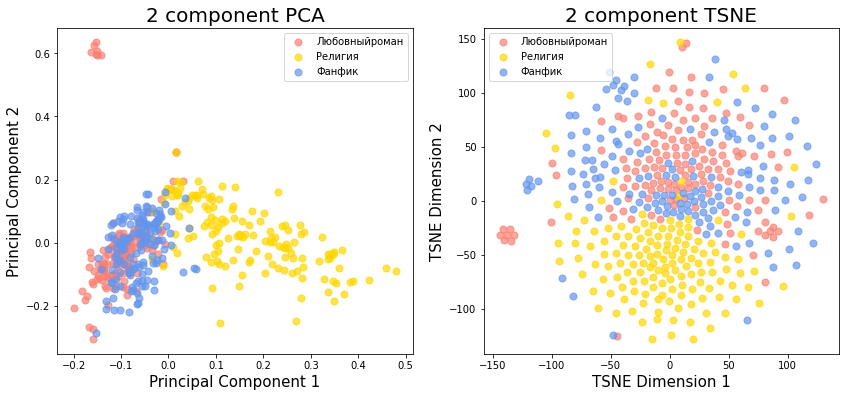

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_xlabel('Principal Component 1', fontsize = 15)
ax[0].set_ylabel('Principal Component 2', fontsize = 15)
ax[0].set_title('2 component PCA', fontsize = 20)
colors = ['salmon', 'gold', 'cornflowerblue']
for dir, color in zip(dirs, colors):
    indicesToKeep = finalDf['genre'] == dir
    ax[0].scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c=color, s=50, alpha=0.7)
ax[0].legend(dirs)

ax[1].set_xlabel('TSNE Dimension 1', fontsize = 15)
ax[1].set_ylabel('TSNE Dimension 2', fontsize = 15)
ax[1].set_title('2 component TSNE', fontsize = 20)
for dir, color in zip(dirs, colors):
    indicesToKeep = tsneDf['genre'] == dir
    ax[1].scatter(tsneDf.loc[indicesToKeep, 'tsne dimension 1'],
               tsneDf.loc[indicesToKeep, 'tsne dimension 2'],
               c=color, s=50, alpha=0.7)
ax[1].legend(dirs)

## [6 баллов] Задача о тематическом моделировании



### об LDA




### Постановка задачи
Загрузите [коллекцию писем Х. Клинтон](https://www.kaggle.com/kaggle/hillary-clinton-emails/?select=Emails.csv) с kaggle. Для скачивания может потребоваться регистрация.

Методом LDA выделите несколько тем в переписке Х. Клинтон, дайте им словесное описание. Используйте библиотеку LdaModel из gensim.

#### Критерии

* **2 БАЛЛА**: получены списки ключевых слов, не выглядящие бессмыслицей
* **2 БАЛЛА**: осуществлена визуализация библиотекой pyLDAvis
* **1 БАЛЛ**: предложено осмысленное текстовое описание большинства выделенных тем.
* **1 БАЛЛ**: проведено сравнение LDA, запущенного на CountVectorizer и TfIdfVectorizer предтавлениях одних и тех же данных. 

#### примеры кода

Пример обучения LdaModel на выдаче CountVectorizer: [ссылка](https://github.com/EricSchles/sklearn_gensim_example/blob/master/example.py)

Пример использования pyLDAvis: секция 15 [по ссылке](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

---

Для обучения *LdaModel* и её последующей визуализации потребуется словарь формата gensim. Словарь формата gensim удобно получать из сжатого csc_matrix-представления нашего векторизованного текста: как многие замечали на паре, tf-idf векторы содержат много нулей.

```python
import gensim
from scipy.sparse import csc

corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, vocab_dict)
```

где *corpora* содержит полученное с помощью gensim представление коллекции, а *vocab_dict* — это dict, полученный после работы Vectorizer, ставящий в соответствие каждому номеру строки в матрице данных само слово в виде строки.

In [ ]:
! pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
emails = pd.read_csv('Emails.csv', index_col=0)

In [ ]:
emails.head()

In [ ]:
import calendar

In [ ]:
english_stopwords = stopwords.words("english") + ['docx', 'fw', 'pm', 'am', 'fwd', 'f', 'doc', 'h', 'fyi', 'thx', 'state', 'department'] + [month.lower() for month in calendar.month_name[1:]] + ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

In [ ]:
def lemmatize_text_eng(text):
    lemmas = []
    reg = re.compile('[^a-zA-Z ]')
    match = re.findall(r'[\w\.-]+@[\w\.-]+', text.lower())
    doc = nlp(text)
    for tok in doc:
        if tok.lower_ not in punctuation and tok.lower_ not in match and tok.lower_ not in english_stopwords:
            if tok.lemma_ == "-PRON-":
                tok = tok.lower_
            else:
                tok = reg.sub('', tok.lemma_.lower().strip())
            tok = tok.strip()
            if tok != '':
                lemmas.append(tok)
    return lemmas

In [ ]:
emails.dropna(subset=['ExtractedBodyText'], inplace=True)

In [ ]:
corpus = emails.ExtractedBodyText.progress_apply(lambda text: lemmatize_text_eng(text))

In [ ]:
tfidf = TfidfVectorizer(min_df=10,
                        max_df=0.7,
                        max_features=20000,
                        use_idf=True,
                        stop_words=english_stopwords)

In [ ]:
X = tfidf.fit_transform([' '.join(text) for text in corpus])
vocab = tfidf.get_feature_names()

In [ ]:
corp = matutils.Sparse2Corpus(X.T)
dictionary = gensim.corpora.Dictionary.from_corpus(corp, dict([(i, s) for i, s in enumerate(vocab)]))

In [ ]:
# Fit LDA
lda = LdaModel(corp, num_topics=10,
                    passes=20,
                    id2word=dictionary)

In [ ]:
topics = lda.print_topics(num_topics=-1, num_words=10)
for topic in topics:
    print([re.search(r'\"(.+)\"', word).group(1) for word in topic[1].split('+')])

['say', 'us', 'great', 'obama', 'high', 'one', 'president', 'make', 'government', 'new']
['call', 'talk', 'get', 'want', 'would', 'know', 'tomorrow', 'back', 'let', 'work']
['huma', 'abedin', 'lauren', 'blackberry', 'copy', 'send', 'email', 'nice', 'note', 'via']
['cheryl', 'mills', 'discuss', 'update', 'dan', 'min', 'yet', 'date', 'call', 'fine']
['think', 'see', 'thank', 'woman', 'happy', 'message', 'well', 'get', 'tell', 'travel']
['yes', 'release', 'part', 'hillary', 'declassify', 'traffic', 'yep', 'read', 'come', 'reason']
['sullivan', 'jacob', 'statement', 'haiti', 'take', 'united', 'public', 'us', 'number', 'bb']
['add', 'pi', 'list', 'thank', 'call', 'pls', 'fax', 'mitchell', 'sure', 'info']
['print', 'pls', 'pis', 'office', 'secretary', 'meeting', 'room', 'secure', 'melanne', 'arrive']
['ok', 'see', 'good', 'sound', 'letter', 'go', 'call', 'prepare', 'asap', 'dinner']


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corp, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.244431  0.035831       1        1  21.760978
0     -0.010409 -0.243190       2        1  19.546889
4      0.189715  0.040259       3        1  17.240802
6     -0.146559  0.192174       4        1  13.538677
8     -0.090461 -0.099129       5        1   5.652018
3     -0.044667  0.022579       6        1   5.098531
2     -0.074140  0.024748       7        1   4.669348
9      0.044309  0.040488       8        1   4.411699
7     -0.003845 -0.001646       9        1   4.120647
5     -0.108376 -0.012116      10        1   3.960411, topic_info=        Term        Freq       Total Category  logprob  loglift
2099      ok  171.000000  171.000000  Default  30.0000  30.0000
2364   print  113.000000  113.000000  Default  29.0000  29.0000
2273     pls  123.000000  123.000000  Default  28.0000  28.0000
3376     yes   84.000000   84.000000  Default  27.0000  27.0000
496   cheryl   70.000000   70.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
1219  follow    6.819611   36.697524  Topic10  -4.7393   1.5459
2791     sid    6.359974   32.760000  Topic10  -4.8090   1.5896
1977      ms    4.209016   10.044452  Topic10  -5.2218   2.3590
2727     see    6.663865  120.438676  Topic10  -4.7624   0.3344
1636    john    3.838473   13.798251  Topic10  -5.3140   1.9494

[559 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         1  0.105585     abedin
3         7  0.886914     abedin
17        3  0.960130     access
33        4  0.912834     action
44        2  0.121209        add
...     ...       ...        ...
3377      5  0.047364  yesterday
3378      1  0.312875        yet
3378      3  0.243347        yet
3378      6  0.417166        yet
3382      7  0.630662     zelaya

[945 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 7, 9, 4, 3, 10, 8, 6])

In [ ]:
countvec = CountVectorizer(min_df=10,
                           max_df=0.5,
                           stop_words=english_stopwords)

In [ ]:
Y = countvec.fit_transform([' '.join(text) for text in corpus])
vocab_y = countvec.get_feature_names()

In [ ]:
corp_y = matutils.Sparse2Corpus(Y.T)
dictionary_y = gensim.corpora.Dictionary.from_corpus(corp_y, dict([(i, s) for i, s in enumerate(vocab_y)]))

In [ ]:
# Fit LDA.у
lda_y = LdaModel(corp_y, num_topics=10,
                    passes=20,
                    id2word=dictionary_y)

In [ ]:
topics = lda_y.print_topics(num_topics=-1, num_words=20)
for topic in topics:
    print([re.search(r'\"(.+)\"', word).group(1) for word in topic[1].split('+')])

['secretary', 'office', 'meeting', 'room', 'arrive', 'route', 'depart', 'en', 'private', 'conference', 'time', 'staff', 'residence', 'house', 'daily', 'floor', 'foreign', 'washington', 'minister', 'airport']
['cheryl', 'huma', 'mills', 'sullivan', 'abedin', 'jake', 'jacob', 'see', 'work', 'statement', 'memo', 'wjc', 'cdm', 'read', 'agree', 'follow', 'marie', 'draft', 'think', 'discuss']
['ok', 'part', 'release', 'party', 'labour', 'yes', 'sid', 'cameron', 'david', 'brown', 'gordon', 'vote', 'minister', 'northern', 'last', 'min', 'sbwhoeop', 'say', 'uup', 'week']
['us', 'united', 'new', 'states', 'diplomacy', 'nuclear', 'work', 'development', 'woman', 'world', 'country', 'global', 'secretary', 'international', 'support', 'make', 'issue', 'need', 'economic', 'effort']
['pls', 'print', 'thank', 'email', 'good', 'hrc', 'please', 'travel', 'boehner', 'send', 'get', 'press', 'hillary', 'copy', 'message', 'dialogue', 'need', 'qddr', 'strategic', 'check']
['say', 'one', 'american', 'year', 'us

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_y, corp_y, dictionary_y)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.036664  0.138988       1        1  32.384416
8      0.031316  0.144806       2        1  15.642654
6      0.029166  0.181688       3        1  14.198732
7     -0.204411 -0.016504       4        1  10.050710
3      0.162214  0.120074       5        1   8.518706
0      0.201637 -0.252111       6        1   6.247738
1     -0.144107 -0.033746       7        1   3.797306
9      0.210132 -0.126695       8        1   3.201359
4     -0.200945 -0.198950       9        1   3.020784
2     -0.121666  0.042449      10        1   2.937594, topic_info=           Term         Freq        Total Category  logprob  loglift
2721  secretary  1367.000000  1367.000000  Default  30.0000  30.0000
2091     office  1106.000000  1106.000000  Default  29.0000  29.0000
414        call  1504.000000  1504.000000  Default  28.0000  28.0000
3215         us  1841.000000  1841.000000  Default  27.0000  27.0000
1445      house   938.000000   938.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3303       week    68.762478   477.646091  Topic10  -4.7270   1.5894
2688        say    69.897006  2060.539392  Topic10  -4.7107   0.1439
3089      today    54.516476   635.240069  Topic10  -4.9592   1.0721
2727        see    54.328765  1123.453577  Topic10  -4.9626   0.4985
1319         go    53.349536  1091.203972  Topic10  -4.9808   0.5094

[659 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3         4  0.026220  abedin
3         7  0.964884  abedin
27        1  0.983447  accuse
44        1  0.266894     add
44        3  0.129634     add
...     ...       ...     ...
3375      5  0.968452     yep
3376      1  0.022205     yes
3376      2  0.022205     yes
3376      4  0.447805     yes
3376     10  0.503318     yes

[1482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 7, 8, 4, 1, 2, 10, 5, 3])

Описание тем:



1. мне кажется, что первая тема объединяет какие-то общие разговоры о правительстве и о внутренней/внешней политике США
2. вторая тема гораздо более узкая, покрывает письма о военных действиях в арабских странах, в Афганистане, в Палестине, в Израиле
3. тема выборов и партий, демократы, консерваторы, республиканцы, Белый дом
4. похоже на повседневные письма о встречах, работе, звонках и других обсуждениях
5. разговоры о внешней политике (?) и экономике, дипломатия
6. обсуждение поездок, конференций, встреч
7. кажется, будто в 7 тему попали переписки с ближайшими советниками и приближенными Клинтон (Cheryl Mills, Huma Abedin, Jake Sullivan) или письма с их упоминаниями
8. разговоры о положении в Ливии (Триполи, Бенгази), информация, соглашения, закон о свободе информации (foia)
9. похоже на какие-то рабочие вопросы, связанные с письмами, связями, (личными) просьбами (используются сокращения)
10. тоже похоже на какие-то личные переписки с коллегами по работе, обращение по именам, примечательно "ok" как маркер темы, возможно, также речь о трудовых правах (labour)





Разница между TfIdfVectorizer и CountVectorizer:

Вполне очевидно, что в случае с CountVectorizer формулировка выделенных тем гораздо проще, чем в случае с TfIdf. Похоже, что в нашем случае данные о частотности в документе и в коллекции как будто мешают разделению писем по тематикам. Так, например, в первых трех темах, выделенных с помощью TfIdf матрицы, довольно много частотных слов (глаголов), ничего не говорящих о тематике писем. Даже в списке топ-30 "выдающихся" слов (salient terms) после tfidf нет каких-то выделяющихся маркеров, как, например, obama, vote, benghazi в случае с CountVectorizer. После TfIdf даже не удается выделить тему с войнами в арабских странах, которая, по идее, просматривается довольно четко.